# Decomposition Methods on a spectral grid

This first cell is importing the short_spec_cv_grid into the notebook. This cell must be run first. 

The output of the cell is a selection of different 'python' grids. All grids are in flux space. Each transformation is cumulative. You have:

- **`grid`**: This is the original 'python' spectral grid. You have 125 spectra. 
- **`normalised_grid`**: This spectral grid is the original grid, normalised by the spectrum's mean flux value dividing each flux value.
- **`centred_grid`**: This spectral grid is the normalised grid, centred on the axis by subtracting the mean column flux of each flux value in that respective column.
- **`whitened_grid`**: This spectral grid is the normalised and centred grid with the column flux values divided by the standard deviation of the column's flux.

All grids are shape $N_{spectra} * \vec{F}$, where $\vec{F}$ is the flux vector of a spectrum for the specific wavelength range. i.e. A row is a spectrum, the column is a wavelength bin. 

#### INPUTS

The wavelength range is changeable between the values of 850-1850Å.

The inclination of the grid is changeable between 30-85 degrees.

See below --

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import fnmatch
import itertools
plt.style.use('Solarize_Light2')

# Creating the flux grid space
files = os.listdir('short_spec_cv_grid/') # list of files in directory
sorted_files = []
for num in range(1,126): # run number ranges
    if len(str(num)) == 1: # adding 0 to single digit run numbers
        run = f'run0{num}_'
    else:
        run = f'run{num}_'
    file = fnmatch.filter(files, run+'*') # matching file with loop run number
    sorted_files.append('short_spec_cv_grid/'+str(file[0])) # files sorted in order of run number
    
# ------------------- #
wavelength_range = (1510,1590) # set desired wavelength range
inclination_column = 16 # 10-21 = 30-85 degrees, 5 degree increments. column number for inclination
# ------------------- #

# wavelengths in angstroms ordered by reversing list 
wavelengths = np.loadtxt(sorted_files[0], usecols=1, skiprows=81)[::-1]
wave_mask = (wavelengths > wavelength_range[0]) & (wavelengths < wavelength_range[1]) # mask for wavelength range
wavelengths = wavelengths[wave_mask] # updating to new wavelength range
grid = np.empty((len(sorted_files), len(wavelengths))) # empty array to store flux values
for i in range(len(sorted_files)):
    flux = np.loadtxt(sorted_files[i], usecols=inclination_column, skiprows=81)[::-1] # flux values for each file
    grid[i] = flux[wave_mask] # adding fluxes into the grid

# Creating the unique combinations of grid points (len(125))   
grid_points = np.array([np.log10([4.e-11, 1.e-10, 4.e-10, 1.e-09, 3.e-09]),[2, 5, 8, 12, 16], [1, 1.5, 2, 2.5, 3]])
unique_combinations = []
for i in itertools.product(*grid_points):
    unique_combinations.append(list(i))

# Normalising, centring and whitening the grid
norm_factor = np.mean(grid, axis=1)[:,None] # normalisation factor
normalised_grid = grid/norm_factor # normalising the grid
centre_factor = np.mean(normalised_grid, axis=0) # centring factor
centred_grid = normalised_grid - centre_factor # centring the grid
whiten_factor = np.std(centred_grid, axis=0) # whitening factor
whitened_grid = centred_grid/whiten_factor # whitening the grid
factors = {'norm':norm_factor, 'centre':centre_factor, 'whiten':whiten_factor} # storing factors for later use

## DECOMPOSITION METHODS

This code cell runs all the different decomposition methods. Notes to be added here in time. 

The grid is split into two, the training data and the testing data. Each method learns "principal components", or whatever the alternative equivalent is, on the training data. The principal components are then applied to the testing data to 'emulate' the outcome without prior knowledge. The data split is shuffled so the 'emulation' is interpolated rather than extrapolated. The grid points are equally split so we can easily see which spectrum is which grid point. 

I have temporary defaulted the arguments and components to 10. Random_state set to 42 for reproducibility. 

#### Methods ---

Documentation User Guide of methods: https://scikit-learn.org/stable/modules/decomposition.html

Most sci-kit learn routines have a similar template method of:

* `model = Model()`
* `model.fit(train_data).transform(test_data)` or `model.fit_transform(train_data)`
* `predictions = model.predict(test_data)` or `predictions = model.inverse_transform(test_data)`

For speed of work as this notebook is not intended for sustained use, the method descriptions below are AI generated.

### <u>METHOD 1: PCA 2.5.1.1</u>
This is regular PCA the Starfish used. We are familiar with this. 

CHATGPT4 AI: Principal Component Analysis (PCA) is a widely-used technique in statistics and machine learning for dimensionality reduction. It helps to transform high-dimensional data into a lower-dimensional form, retaining as much of the data's variance as possible.

Here's a step-by-step description of the PCA process:

1. **Standardization**:
   - Before applying PCA, it's common to standardize the data. This means transforming the data such that each feature has a mean of 0 and a standard deviation of 1. This is important because PCA is sensitive to the magnitudes of the variables.

2. **Compute the Covariance Matrix**:
   - Once the data is standardized, compute the covariance matrix. The covariance matrix captures the linear relationship between the features. If you have \(n\) features, this will be an \(n \times n\) matrix.

3. **Calculate Eigenvectors and Eigenvalues**:
   - Eigenvectors and eigenvalues are derived from the covariance matrix. They are fundamental to the PCA process.
   - Eigenvalues indicate the magnitude of variance captured by each eigenvector. In other words, they provide the "importance score" for each eigenvector.
   - Eigenvectors represent the directions of maximum variance in the data. They are orthogonal to each other, meaning they are at right angles to one another in n-dimensional space.

4. **Sort Eigenvalues and Corresponding Eigenvectors**:
   - Order the eigenvalues from largest to smallest. This provides a ranking of the eigenvectors based on the amount of variance they capture from the original data.

5. **Choose Principal Components**:
   - Once sorted, decide how many principal components you want to retain. This decision is based on the cumulative variance captured by the eigenvectors and the specific needs of your analysis.
   - Typically, you might choose the top k eigenvectors (those corresponding to the largest eigenvalues) to capture a sufficient proportion of the data's variance.

6. **Project Original Data**:
   - Using the chosen eigenvectors, transform the original data into the lower-dimensional space. This involves taking the dot product between the original data and the selected eigenvectors.

The result of this process is a set of principal components, which are linear combinations of the original features. These principal components are uncorrelated, and each one captures a decreasing amount of the total variance of the original data. The idea is to use fewer principal components to capture most of the variance, effectively reducing the dimensionality of the data.

In many applications, visualizations using the first two or three principal components can offer insights. In machine learning, using the principal components rather than the original features can sometimes improve model performance and generalization by reducing the risk of overfitting and speeding up training.

##### Recommend data pre-processing - 

CHATGPT4 AI: When working with astrophysical spectra, preprocessing is essential for the success of PCA or any other dimensionality reduction technique. Here are some crucial preprocessing steps and considerations tailored for spectral data:
Given that the spectral data is simulated and doesn't suffer from the issues commonly associated with observational data, the preprocessing becomes more straightforward. Here's a revised list tailored to clean, simulated spectra:

1. **Flux Normalization**:
   - Even in simulated data, the overall flux levels might differ due to the parameters of your simulation or the nature of the objects you're simulating. Normalizing each spectrum to have the same total flux (or sometimes peak flux) ensures that PCA focuses on the shape and intrinsic features of the spectra rather than absolute magnitudes.

2. **Continuum Subtraction or Normalization**:
   - If your simulated spectra include a continuum component, you might want to subtract this continuum to emphasize the absorption and emission features. Alternatively, you can normalize by the continuum to bring out relative variations in the spectra's features.

3. **Standardization**:
   - It's still essential to standardize each wavelength bin (column) such that it has a mean of 0 and a standard deviation of 1. Standardizing ensures that all parts of the spectrum, irrespective of their absolute flux values, contribute equally to the PCA process.

4. **Redshift Correction (if applicable)**:
   - If your simulated data includes effects like redshift, and you want spectra at their rest wavelengths, then correct for this redshift. This ensures that the features in your spectra are aligned and directly comparable, which is especially relevant if your simulations span a range of redshifts.

5. **Smoothing or Denoising (if desired)**:
   - While your simulated data may not have observational noise, you might still want to smooth or denoise the spectra, especially if the simulations introduce computational noise or if you want to focus on broader features over fine details.

Once you've preprocessed the simulated spectra according to these steps, you can proceed with PCA. Given that simulated datasets often span a wide parameter space, PCA can be a powerful tool to identify the primary modes of variation in the data and can help in understanding the underlying physics driving those variations.

### <u>METHOD 2: Kernel PCA 2.5.2</u>

CHATGPT4 AI: 

Kernel PCA is an extension of the traditional PCA, which allows for the capturing of non-linear relationships in the data. Let's walk through its process and then contrast it with the exact PCA.

##### 1. Mapping to a Higher Dimension:
Kernel PCA starts by implicitly mapping the original data into a higher-dimensional space using a kernel function. The idea is that in this higher-dimensional space, the data becomes more "spread out" and possibly linearly separable, even if it wasn't in the original space.

##### 2. Compute Kernel Matrix:
Instead of directly working in this high-dimensional space (which can be computationally challenging or even impossible, as the space can be infinite-dimensional for some kernels), Kernel PCA works with a kernel matrix. The kernel matrix is an \(n \times n\) matrix (where \(n\) is the number of data points), with each element \(K(i,j)\) being the result of the kernel function applied to data points \(i\) and \(j\). Common kernel functions include the polynomial kernel, radial basis function (RBF or Gaussian) kernel, and the sigmoid kernel.

##### 3. Centering the Kernel Matrix:
Before performing eigendecomposition, the kernel matrix is centered. This is analogous to subtracting the mean in the original data space.

##### 4. Eigendecomposition of Kernel Matrix:
Find the eigenvalues and eigenvectors of the centered kernel matrix. These are used to extract the principal components in the higher-dimensional space.

##### 5. Extracting Principal Components:
The principal components in the kernel PCA are the eigenvectors of the kernel matrix, sorted by their corresponding eigenvalues in descending order.

##### How Kernel PCA differs from exact (linear) PCA:

1. **Linearity vs. Non-linearity**:
   - **PCA**: Assumes that the principal components are linear combinations of the original features. It seeks to find the directions (in the original space) of maximum variance.
   - **Kernel PCA**: Captures non-linear relationships by implicitly mapping data to a higher-dimensional space where these relationships might be linear.

2. **Data Transformation**:
   - **PCA**: The original data is directly transformed by projecting it onto the principal components.
   - **Kernel PCA**: Works in the higher-dimensional feature space, and the kernel matrix represents similarities between data points in this space. The data isn't directly transformed to this space; instead, the kernel function provides a measure of similarity.

3. **Computational Aspects**:
   - **PCA**: Involves the eigendecomposition of the data's covariance matrix.
   - **Kernel PCA**: Involves the eigendecomposition of the kernel matrix, which can be computationally intensive for large datasets.

4. **Interpretability**:
   - **PCA**: The principal components are linear combinations of the original features, so they can be interpreted in terms of the original data.
   - **Kernel PCA**: The principal components represent directions in the high-dimensional space, and they don't have a direct interpretation in terms of the original features.

For the astrophysical spectra grid, if the variations and relationships within the spectra are believed to be non-linear, Kernel PCA might be more suitable than linear PCA. However, the choice of kernel and its parameters would be crucial. On the other hand, if the primary sources of variance in the spectra are linear, traditional PCA might suffice and offer more interpretable results.

#### Data pre-processing 

CHATGPT4 AI:
When using Kernel PCA, especially with scikit-learn's implementation, there are several preprocessing steps that are particularly crucial for spectral data. Here's what you need to consider:

1. **Flux Normalization**:
   - Even if the data is simulated, normalization ensures that Kernel PCA focuses on the shape and intrinsic features of the spectra rather than differences in magnitudes. You can normalize each spectrum such that the total flux or peak flux is consistent across all spectra.

2. **Standardization**:
   - Unlike linear PCA, the importance of standardization in Kernel PCA is somewhat kernel-dependent. However, for many kernels, especially the Gaussian (RBF) kernel, standardizing each wavelength bin (i.e., each column) so that it has a mean of 0 and a standard deviation of 1 is crucial. This ensures that all parts of the spectrum contribute equally to the kernel matrix and prevents high-variance features from dominating.

3. **Continuum Subtraction or Normalization**:
   - If your simulated spectra have a continuum, consider subtracting or normalizing by it. This makes spectral features such as absorption and emission lines more prominent and provides a clearer comparison of shapes and patterns in the spectra.

4. **Choosing the Right Kernel**:
   - The choice of kernel in Kernel PCA is crucial. While the Gaussian (RBF) kernel is a popular choice due to its flexibility in capturing various non-linear patterns, other kernels like polynomial might be more appropriate for certain datasets. You may need to experiment with different kernels and their parameters to find the best fit for your spectral grid.

5. **Kernel Parameter Tuning**:
   - Once a kernel is chosen, tuning its parameters is vital. For instance, the RBF kernel has a parameter \( \gamma \) which controls the shape of the similarity function. A cross-validation approach, possibly using some labeled data or a measure of cluster separation, can help determine the optimal parameters.

6. **Redshift Correction (if applicable)**:
   - If your simulated data includes effects like redshift, correcting for this ensures that spectral features are aligned and directly comparable.

7. **Smoothing or Denoising (if desired)**:
   - If you want to focus on broader features over fine details in the spectra, consider smoothing the data, especially if there are small-scale noise or computational artifacts.

One significant aspect to consider when using Kernel PCA is the computational cost. Kernel PCA's complexity grows with the size of your dataset, so for large spectral grids, memory and computational time can become concerns. This is due to the necessity of computing and storing the kernel matrix, which is \(n \times n\), where \(n\) is the number of spectra.

Finally, once you've applied Kernel PCA, it's essential to validate the results, possibly by visualizing the first few principal components or by using them in subsequent analyses, to ensure that they capture meaningful patterns in the data.

### <u>METHOD 3: Truncated SVD 2.5.3</u>

CHATGPT AI: Truncated Singular Value Decomposition (Truncated SVD) is a popular technique for dimensionality reduction, particularly when dealing with sparse matrices. It's often used in the context of Latent Semantic Analysis (LSA) for text data. Here's a step-by-step description of the process:

## Truncated SVD:

### 1. Singular Value Decomposition (SVD):
Begin with the standard SVD of a data matrix $X$. The SVD decomposes $X$ into three matrices:

$ X = U \Sigma V^T $

- $U$ and $V$ are orthogonal matrices. 
  - $U$ (left singular vectors) relates to the rows of $X$.
  - $V$ (right singular vectors) relates to the columns of $X$.
- $\Sigma$ is a diagonal matrix whose diagonal entries are the singular values of $X$. These singular values are non-negative and are generally sorted in decreasing order.

### 2. Truncation:
In the "Truncated" SVD, instead of keeping all singular values and vectors, you keep only the top $k$, where $k$ is a chosen number smaller than the original number of features (or documents, in the case of LSA).

Thus, from $U \Sigma V^T$, you get:

- $U_k$: The first $k$ columns of $U$.
- $\Sigma_k$: The top-left $k \times k$ block of $\Sigma$ (i.e., the largest $k$ singular values).
- $V_k^T$ : The first $k$ rows of $V^T$.

### 3. Reduced Representation:
Your reduced data matrix $X_k$ is then:

$X_k = U_k \Sigma_k$

This $X_k$ retains most of the original data's variance or structure but is of lower dimensionality. The approximation of $X$ using only $k$ singular values and vectors is the best rank-$k$ approximation in terms of the Frobenius norm.

### Differences from PCA:

While Truncated SVD and PCA are closely related and can yield similar results for mean-centered data, there's a key distinction:

- **Mean Centering**: PCA implicitly mean-centers the data before applying SVD, which means the principal components are orthogonal to the mean. Truncated SVD does not require mean-centering. This distinction is particularly relevant when dealing with sparse data, where subtracting the mean would make the data dense.

## Application to Spectral Grid:

For your astrophysical spectra grid:

1. If the grid is dense, you can directly apply Truncated SVD.
2. Decide on the number of components $k$. Often, a scree plot (plotting the singular values) can help identify a suitable $k$ where most of the variance is captured but with reduced dimensionality.
3. As with other dimensionality reduction techniques, preprocessing like normalization and standardization remains essential. Especially with Truncated SVD, scaling each spectrum (row) to have unit norm can sometimes be beneficial.

Truncated SVD can be efficient for large datasets because it doesn't require the computation of the covariance matrix, as PCA does. This makes it particularly useful for high-dimensional data where the number of features (in your case, wavelength bins) is very high.


## Data pre-processing 

CHATGPT4 AI: For your spectral grid, and with consideration of scikit-learn's Truncated SVD algorithm, here's a systematic guide to the preprocessing steps:

1. **Flux Normalization**:
   - Normalize each spectrum to make sure that the Truncated SVD focuses on the shape and intrinsic features of the spectra rather than the magnitudes. You can normalize such that the total flux or peak flux is consistent across all spectra.

2. **Standardization**:
   - Although Truncated SVD doesn't inherently require mean-centering like PCA does, standardizing the data often yields better results, particularly if the scales of the flux values differ widely across wavelength bins. You'd standardize each wavelength bin (column) to have a mean of 0 and a standard deviation of 1. 

3. **Row Normalization**:
   - For some applications, especially in text processing like LSA, it's common to scale each row (document or, in your case, spectrum) to have a unit norm. This can be useful if you want each spectrum to contribute equally, irrespective of its overall magnitude.

4. **Handling Missing Values**:
   - If there are any missing values in your grid, they should be imputed. Given that your data is simulated and probably doesn't have gaps, this might not be an issue. However, if it's relevant, a simple method would be to interpolate missing values or impute them with the mean or median value of the respective wavelength bin.

5. **Data Reduction (if necessary)**:
   - If your grid is extremely large, you might consider reducing its size before applying Truncated SVD, either by selecting a subset of the spectra or by binning the wavelengths to create broader wavelength bins. This step is more about computational efficiency than a strict requirement of the algorithm.

6. **Choose Number of Components**:
   - The number of components \(k\) you want to keep after Truncated SVD is crucial. While you can start with a reasonable estimate, you might want to analyze the explained variance as a function of \(k\) (using a scree plot) to decide on an appropriate number of components that capture the most essential features of the data without keeping unnecessary dimensions.

7. **Smoothing or Denoising (if desired)**:
   - This step isn't strictly necessary for Truncated SVD, but if your simulated spectra have small-scale variations or computational noise that you believe isn't relevant, consider smoothing the spectra before dimensionality reduction. This can help the Truncated SVD to focus on broader, more significant features.

Once you've preprocessed your spectral grid as described, you can confidently proceed with the Truncated SVD in scikit-learn, ensuring that the reduced dimensions capture the most significant structures and patterns in your data.An important aspect to remember with Truncated SVD is that, unlike PCA, the transformed data does not represent orthogonal directions of maximum variance in the original data. Instead, it provides the best rank-$k$ approximation to the original data. As always, after applying the dimensionality reduction, it's beneficial to validate and visualize the results to ensure meaningful patterns in the spectra are captured.

### <u>METHOD 4: Factor Analysis 2.5.5</u>

CHATGPT4 AI: Factor Analysis (FA) is a technique primarily used in psychology, social sciences, and other fields to uncover the latent structure (i.e., variables that are not directly observed but rather inferred from other variables) of a set of observed variables. It assumes that observed variables are influenced by common factors and unique factors.

Here's a description of the Factor Analysis process:

### Factor Analysis Process:

1. **Model Assumption**:
   FA assumes that there are underlying factors that affect the observed variables. The relationship can be expressed as:
   
   $X = LF + U$

   Where:
   - $X$ is the observed data.
   - $L$ is the factor loading matrix that represents the relationship between factors and observed variables.
   - $F$ is the matrix of factors.
   - $U$ represents unique factors (including errors) that affect each observed variable.

2. **Extraction of Factors**:
   Initially, all variability in an observed variable is considered unique to it. The FA process determines how much of this variability is shared with other observed variables due to common factors. Several methods can be employed to extract these factors, including:
   
   - Principal Component Method
   - Maximum Likelihood Method
   - Principal Axis Factoring

3. **Rotation**:
   After initial extraction, factors are usually rotated to achieve a simpler and more interpretable structure. Rotation can be orthogonal (like Varimax, where factors remain uncorrelated) or oblique (like Promax, allowing factors to correlate).

4. **Number of Factors**:
   Deciding on the number of factors to retain is crucial. Several criteria can assist in this decision:
   
   - Kaiser's Criterion: Retain factors with eigenvalues greater than 1.
   - Scree plot: A plot of eigenvalues; factors are retained up to the point where the plot levels off.
   - Theoretical considerations or domain knowledge.
   - Variance explained: Choose a number of factors that explain a satisfactory proportion of the variance.

5. **Interpretation**:
   Once factors are extracted and rotated, the next step involves interpreting them. This involves looking at the factor loadings (correlation between original variables and factors) to determine the meaning or construct each factor represents. High loadings (either positive or negative) indicate which observed variables are strongly associated with each factor.

### Differences from PCA:

While FA and PCA can seem similar, they're fundamentally different in their goals and assumptions:

- **Purpose**:
   - PCA aims to represent the maximum variance in data with fewer principal components.
   - FA aims to uncover latent structures and interpretable factors influencing the observed variables.

- **Assumptions**:
   - PCA doesn't differentiate between shared and unique variance.
   - FA tries to model the shared variance among variables and attributes unique variance and error to each individual variable.

- **Components/Factors**:
   - In PCA, components are orthogonal and represent the directions of maximum variance.
   - In FA, factors represent underlying constructs that influence the observed variables, and depending on the rotation, they can be correlated.

For your astrophysical spectral grid, if you wish to interpret underlying factors (maybe some physical processes) that influence the patterns observed across different spectra, then Factor Analysis might be a suitable approach. However, it's crucial to note that FA is heavily reliant on the assumption that there are underlying latent constructs influencing the observed data.

### Pre-processing Data

CHATGPT4 AI: 
For the astrophysical spectral grid, when preparing to employ Factor Analysis (FA) using scikit-learn's implementation, there are several preprocessing steps that are particularly important. Given that FA is designed to uncover latent structures in the data, ensuring that the data is well-prepared can greatly influence the clarity and validity of the results. Here's what you should consider:

1. **Standardization**:
   - This is a crucial step for FA. Ensure that each wavelength bin (i.e., each column) has a mean of 0 and a standard deviation of 1. This ensures that all wavelengths contribute equally to the factor analysis, without any particular range dominating due to larger absolute values or variances.

2. **Flux Normalization**:
   - Just like with other dimensionality reduction techniques, you may want to normalize each spectrum so that they are on a similar scale. This could be ensuring that the total flux or peak flux is consistent across all spectra.

3. **Check for Linearity**:
   - FA assumes linear relationships among variables. For the spectral grid, this means that if one wavelength bin increases (or decreases), others do so in a linear fashion. While this assumption might generally hold for spectra, it's good to visually inspect some spectra or compute correlations between different wavelength bins to ensure linearity.

4. **Remove or Handle Multicollinearity**:
   - If some wavelength bins are highly correlated (which might be the case for neighboring bins in a spectrum), it can impact the FA. You might consider aggregating or averaging closely spaced wavelength bins or removing some of them to reduce multicollinearity.

5. **Continuum Subtraction or Normalization**:
   - If your spectral grid contains a continuum, consider subtracting or normalizing by this continuum. This highlights the absorption and emission features, helping the FA to identify patterns more clearly.

6. **Check for Adequate Sample Size**:
   - FA requires a reasonable sample size to produce reliable results. A common recommendation is the subject-to-variable ratio, with a minimum of 5:1 (subjects or samples to variables or features) often suggested, though more can be better.

7. **Missing Data**:
   - Ensure there are no missing values. If there are any, consider imputation methods to fill them. Given that you're working with simulated data, this might not be a significant concern, but always good to check.

8. **Deciding on the Number of Factors**:
   - Just as with PCA and its components, deciding on the number of factors to retain in FA is critical. While scikit-learn's `FactorAnalysis` implementation will attempt to estimate the number of factors, you can also use techniques like the scree plot, parallel analysis, or Bayesian information criterion (BIC) to decide on the number of factors.

9. **Check for Assumptions**:
   - Beyond linearity, ensure the data meets other assumptions of FA, such as homoscedasticity (equal variance across scores). While these are more relevant for social science applications of FA, it's still good to be aware of them.

Once the preprocessing steps are taken care of, you can proceed with the Factor Analysis using scikit-learn's `FactorAnalysis` class. After the analysis, remember to interpret the factors in the context of the spectral data to make sense of the underlying patterns or processes the factors might be indicating.

### <u>METHOD 5: Fast ICA 2.5.6</u>

CHATGPT4 AI:
Independent Component Analysis (ICA) is a computational method used to separate a multivariate signal into additive, independent (non-Gaussian) components. It's often used in digital signal processing and other applications to extract signals from noisy data. ICA is notably applied in neuroscience for blind source separation of brain signals, for example, separating out different sources of brain activity in EEG data.

Here's a rundown of the ICA process:

### Independent Component Analysis (ICA):

1. **Assumption**:
   ICA operates on the assumption that the observed datasets are linear mixtures of some unknown latent variables (independent components). These components are assumed to be non-Gaussian and statistically independent from each other.

2. **Model**:
   Suppose we have an observed data matrix $X$. ICA assumes that $X$ is produced by a linear combination of some independent components $S$ such that:
   
   $X = AS$
   
   Where:
   - $X$ is the observed data.
   - $A$ is the mixing matrix.
   - $S$ are the independent components.

3. **Goal**:
   The objective of ICA is to find the unmixing matrix \( W \) such that:
   
   \[ S = W \times X \]

   Where $S$ are the estimated independent components. Essentially, we want to invert the mixing matrix $A$.

4. **Centralization**:
   Before applying ICA, the data is usually centralized (mean subtracted).

5. **Whitening**:
   The data is often "whitened" before ICA, which is a transformation that makes the data to have an identity covariance matrix. Whitening simplifies the computations and ensures that the sources are statistically uncorrelated.

6. **Non-Gaussianity**:
   Since the central limit theorem suggests that the sum of independent variables becomes more Gaussian than the originals, ICA exploits this property. The independent components are sought by maximizing the non-Gaussianity of the data. Different algorithms and measures of non-Gaussianity (like kurtosis or negentropy) are used.

7. **Indeterminacy**:
   Two major ambiguities exist in ICA solutions:
   - **Order Indeterminacy**: The order of the components isn't fixed. If you run ICA multiple times, the order of the output components may vary.
   - **Scale Indeterminacy**: ICA can only determine the directions of the components, not their variances (scales). Therefore, the components are typically normalized to have unit variance.

### Comparison with PCA:

- While both PCA and ICA are used for dimensionality reduction or blind source separation, their objectives are different:
   - **PCA** aims to find orthogonal directions of maximum variance in data.
   - **ICA** aims to identify underlying independent sources (components).

- **Assumptions**:
   - PCA assumes that the principal components are orthogonal.
   - ICA assumes that the components are statistically independent and non-Gaussian.

In the context of your astrophysical spectral grid, ICA could be used if you believe that the observed spectra are a mixture of independent sources or processes. ICA would then attempt to separate these underlying sources. For instance, if various processes or phenomena contribute independently to the spectral signatures, ICA could help in identifying and isolating these individual contributions.

### Data pre-processing 

CHATGPT4 AI:

When applying Independent Component Analysis (ICA), especially using scikit-learn's FastICA implementation, preprocessing is crucial. Proper preprocessing ensures that the assumptions of ICA are met and enhances the performance of the algorithm. Here's what you should consider for your astrophysical spectral grid:

1. **Standardization**:
   - Centralize the data by subtracting the mean from each wavelength bin (i.e., each column). This ensures that each feature (wavelength bin) has a mean of 0.
   - Scale each spectrum to have a unit variance. This ensures that all wavelengths contribute equally to the ICA without any particular range dominating due to larger absolute values or variances. In scikit-learn, you can use `StandardScaler` for this purpose.

2. **Whitening**:
   - Whitening (or sphering) the data ensures that it has an identity covariance matrix. This step decorrelates the features and equalizes their variances. Fortunately, the FastICA implementation in scikit-learn takes care of this internally, so you don't need to perform whitening manually.

3. **Flux Normalization**:
   - Depending on the characteristics of the spectral data, it might be useful to normalize each spectrum so that they are on a similar scale. This could involve ensuring that the total flux or peak flux is consistent across all spectra.

4. **Check for Linearity**:
   - ICA assumes linear mixing of the sources. Ensure that the relationships between different wavelength bins or spectral lines are approximately linear. While it's difficult to validate this assumption explicitly, awareness of it is essential.

5. **Ensure Adequate Sample Size**:
   - Like other matrix factorization methods, ICA benefits from a larger sample size. The more spectra you have, the better the ICA can work to identify the independent sources.

6. **Avoid Over-complexity**:
   - When specifying the number of components for ICA (using the `n_components` parameter), be cautious. While it's tempting to extract as many independent components as possible, doing so can lead to overfitting or capturing noise. Often, it's best to start with a smaller number of components and then incrementally increase if necessary.

7. **Missing Data**:
   - Ensure that there are no missing values in your spectral grid. ICA doesn't handle missing data inherently. If missing values are present, consider imputation methods. Given that you're working with simulated data, this might not be a significant concern.

8. **Randomness**:
   - FastICA involves random initializations. Therefore, you might get slightly different results on different runs. If you're aiming for reproducibility, consider setting the `random_state` parameter in the FastICA algorithm.

Once preprocessing is completed, you can apply the FastICA algorithm. After the analysis, it's essential to interpret the independent components in the context of the spectral data, understanding that they represent some form of independent source or process within the observed data.

### <u>METHOD 6: Non-negative Matrix Factorization 2.5.7</u>

CHATGPT4 AI:

Non-negative Matrix Factorization (NMF) is a dimensionality reduction and matrix factorization technique that decomposes a non-negative matrix into the product of two lower-rank non-negative matrices. Because of the non-negativity constraint, NMF is particularly useful in applications where the data and the underlying factors are naturally non-negative, such as in image processing, text mining, and bioinformatics.

Here's a breakdown of the Non-negative Matrix Factorization (NMF) process:

### Non-negative Matrix Factorization (NMF):

1. **Model**:
   Given a non-negative matrix $V$ of size $m \times n$, NMF aims to find two non-negative matrices  $W$ (of size $m \times k$) and $H$ (of size $k \times n$), where $k$ is typically smaller than both $m$ and $n$. This results in the approximation:

   $V \approx W \times H$

   Here:
   - $V$ is the original data matrix.
   - $W$ is the basis or weight matrix.
   - $H$ is the coefficient or feature matrix.
   - $k$ is the number of components or features we're reducing to, which must be specified beforehand.

2. **Objective**:
   The primary goal of NMF is to minimize the reconstruction error between $V$ and the product $W \times H$. Commonly used measures for the reconstruction error include the Frobenius norm or the Kullback-Leibler divergence.

3. **Non-negativity Constraint**:
   What sets NMF apart from other matrix factorization methods is its non-negativity constraint. Both $W$ and $H$ must have only non-negative values. This constraint leads to a parts-based representation of the data, making the results often more interpretable than those of methods that allow negative values, like PCA.

4. **Applications**:
   - **Image Analysis**: NMF can decompose images into their constituent parts.
   - **Text Mining**: When applied to a term-document matrix, NMF can extract topics from a collection of texts.
   - **Bioinformatics**: Used for gene expression analysis and other bioinformatics applications to identify patterns.
   - **Recommender Systems**: For approximating user-item interaction matrices.

5. **Optimization**:
   There are various algorithms to solve the NMF optimization problem, including multiplicative update rules, gradient descent, and alternating least squares. The choice of algorithm can influence the speed of convergence and the quality of the factorization.

6. **Sparsity Constraints**:
   In some applications, additional sparsity constraints on $W$ and/or $H$ can be imposed to get a more interpretable or parsimonious representation.

### Comparison with other methods:

- Unlike PCA, which can produce negative values in its component matrices, NMF ensures all values are non-negative.
- NMF tends to produce more interpretable components, often referred to as a "parts-based" representation, whereas methods like PCA produce orthogonal components.
- NMF doesn't provide an exact decomposition but an approximation. The quality of this approximation depends on the chosen rank $k$ and the specific dataset.

In the context of an astrophysical spectral grid, NMF could potentially help identify distinct non-negative spectral patterns or components in the dataset. Given that spectral data is inherently non-negative, NMF might provide a natural and interpretable decomposition of the data into its constituent parts.

### Data pre-processing 
CHATGPT4 AI:

Preparing your astrophysical spectral grid for Non-negative Matrix Factorization (NMF) using scikit-learn's implementation requires particular attention to ensure the best results. Here's a guide to preprocessing your spectral data:

1. **Ensure Non-negativity**:
   - Since NMF requires non-negative data, ensure all values in your spectral grid are non-negative. This might seem obvious, but it's a fundamental prerequisite. Given that you're working with spectral data, this should naturally be the case, but it's always good to verify.

2. **Scale Data**:
   - While it's not always necessary to scale data for NMF, in certain scenarios, bringing the values within a consistent range can improve results. For spectral data, consider scaling each spectrum so that its maximum value is 1 or its total area (under the curve) is a fixed value.

3. **Remove or Impute Missing Values**:
   - NMF doesn't handle missing values inherently. If your dataset has any missing values (even though your data is simulated, future datasets might), you'll need to address this. You can either remove data points with missing values or use an imputation method to fill them.

4. **Dimensionality**:
   - Consider the dimensionality of your spectral grid. If the dataset is extremely high-dimensional with many redundant features (very finely sampled wavelength bins, for instance), consider a preliminary reduction using another method or binning together closely spaced wavelength intervals.

5. **Choosing the Number of Components**:
   - The `n_components` parameter in scikit-learn's NMF determines the number of components to extract. It's a crucial parameter that can affect the interpretability and utility of the results. While there's no one-size-fits-all value, you might start with a smaller number of components and incrementally increase, evaluating the quality and interpretability of the results at each step.

6. **Regularization**:
   - Scikit-learn's NMF offers options for adding regularization to the factorization process (`alpha` and `l1_ratio` parameters). Regularization can help in achieving smoother and more generalizable components. Depending on the nature of your spectral data, you might want to experiment with these parameters.

7. **Initialization**:
   - NMF's performance can sometimes be sensitive to initialization. Scikit-learn provides different initialization strategies, such as 'random' and 'nndsvd'. If you find that the algorithm is not converging or is providing inconsistent results across runs, consider trying different initialization methods.

8. **Check Convergence**:
   - NMF is an iterative algorithm, and sometimes it might not converge to a solution. Check the convergence by examining the value of the objective function across iterations. Adjusting parameters like `max_iter` (maximum number of iterations) and `tol` (tolerance) can help ensure convergence.

9. **Randomness**:
   - As with other iterative methods, certain initializations might introduce an element of randomness. For reproducibility, consider setting the `random_state` parameter.

After preprocessing and applying NMF, it's essential to inspect the resulting components in the context of the spectral data. In astrophysical contexts, each component might correspond to certain astrophysical processes or phenomena, and their interpretation can yield valuable insights into the data's underlying structure.

### <u>METHOD 7: Sparse PCA 2.5.1.4</u>
Contains `is_fast` switch as can take a longer time to run. Set True or False to run method.

CHATGPT4 AI:

Sparse Principal Component Analysis (Sparse PCA) is a variant of traditional Principal Component Analysis (PCA). While PCA aims to find orthogonal directions (principal components) in the data that capture the maximum variance, Sparse PCA goes a step further by also promoting sparsity in the principal components. This means Sparse PCA attempts to have many of the loadings (coefficients) of each principal component be exactly zero.

Here's a description of the Sparse PCA process:

### Sparse Principal Component Analysis (Sparse PCA):

1. **Objective**:
   - Like standard PCA, the goal of Sparse PCA is to determine a set of orthogonal components that capture the maximum variance in the data.
   - However, Sparse PCA introduces an additional constraint: it seeks components (or eigenvectors) that have a sparse structure. This means that only a subset of the original features contributes significantly to each component, while the others have a loading of exactly zero.

2. **Sparsity Constraint**:
   - This is achieved by adding a sparsity-inducing penalty (often an L1 penalty) to the objective function. The L1 penalty encourages many of the coefficients to shrink to zero.
   - The amount of sparsity can be controlled, often with a parameter. Increasing this parameter promotes more sparsity in the components.

3. **Benefits of Sparsity**:
   - **Interpretability**: Sparse components are often more interpretable than dense ones because only a subset of features contributes significantly to each component. This makes it easier to understand the underlying patterns in the data.
   - **Feature Selection**: Sparse PCA can also be seen as a form of feature selection, as it identifies a subset of original features that are most relevant for each principal component.

4. **Optimization**:
   - Sparse PCA's optimization problem is more complex than that of standard PCA due to the non-smooth nature of the L1 penalty.
   - Various algorithms, like coordinate descent, have been developed to solve the Sparse PCA optimization problem. However, finding the global optimum is generally challenging, and the solutions are often local optima.

5. **Applications**:
   - Sparse PCA can be beneficial in situations where the data has many features, and it's believed that only a subset of them is genuinely relevant. It's particularly useful in domains like genomics, where one might believe that only a subset of genes is relevant for a particular condition or phenotype.
   - It's also helpful in scenarios where interpretability is paramount, as the sparse loadings make it easier to discern which features are driving each principal component.

6. **Difference from Other Techniques**:
   - Unlike methods such as Lasso (which promotes sparsity in regression coefficients), Sparse PCA promotes sparsity in the loadings of the principal components.
   - Other techniques, like Truncated PCA or Regularized PCA, might reduce dimensionality or avoid overfitting, but they don't necessarily produce sparse loadings.

In the context of dimensionality reduction, Sparse PCA can provide a more concise and interpretable representation of the data by emphasizing only the most crucial features in each component, making it easier to understand the underlying structure and relationships in the dataset.

### Data pre-processing

CHATGPT4 AI:

Preparing your astrophysical spectral grid for Sparse PCA using scikit-learn's `SparsePCA` algorithm involves several steps to ensure optimal results. Here's a guide to preprocessing your spectral data:

1. **Centering**:
   - **Importance**: Just like with standard PCA, it's crucial to center your data, i.e., subtract the mean of each feature.
   - **How-to**: Scikit-learn's `SparsePCA` does not center the data automatically, so you should perform this step manually or use the `StandardScaler` with `with_mean=True` and `with_std=False`.

2. **Scaling**:
   - **Importance**: Depending on the nature of your spectral grid, features (wavelength bins) might be on different scales. Scaling ensures that each feature contributes equally to the analysis.
   - **How-to**: Use scikit-learn's `StandardScaler` with `with_mean=True` and `with_std=True` to both center and scale the data.

3. **Determine the Amount of Sparsity**:
   - **Importance**: The sparsity of the components in Sparse PCA is controlled by the `alpha` parameter in scikit-learn's implementation. You'll need to select an appropriate value.
   - **How-to**: Experiment with different values of `alpha`. A larger `alpha` will result in sparser components. Depending on the problem, cross-validation can help in determining a suitable `alpha`.

4. **Number of Components**:
   - **Importance**: Decide on the number of sparse components you want to extract.
   - **How-to**: The `n_components` parameter in `SparsePCA` determines this. Depending on your specific goals and the structure of your data, you can start with a lower number and increase it based on the explained variance or the interpretability of the components.

5. **Method of Sparse Coding**:
   - **Importance**: Scikit-learn offers various methods to achieve sparse coding.
   - **How-to**: The `ridge_alpha` parameter controls the amount of L2 regularization in the coding. This can be adjusted depending on the level of sparsity and orthogonality desired in the components.

6. **Memory and Computational Efficiency**:
   - **Importance**: Sparse PCA can be computationally intensive, especially with large datasets.
   - **How-to**: Consider using the `randomized` method (via the `method` parameter) for an approximated, faster solution if computational time is a concern. Additionally, adjusting the `max_iter` parameter (maximum number of iterations) can also influence the computational time and convergence.

7. **Convergence**:
   - **Importance**: Sparse PCA is an iterative algorithm and might not always converge.
   - **How-to**: Monitor convergence by checking if the algorithm reached the maximum number of iterations (`max_iter`). Adjusting parameters like `tol` (tolerance) can also help ensure convergence.

8. **Consistent Results**:
   - **Importance**: Due to its iterative nature and multiple possible local minima, Sparse PCA might yield slightly different results across runs.
   - **How-to**: For reproducibility, consider setting the `random_state` parameter.

Once the preprocessing is done and Sparse PCA is applied, always review the resulting components. Given the astrophysical context of the spectral grid, the sparse nature of the components should make it easier to interpret which specific wavelength bins (features) are most significant in each component.


### <u>METHOD 8: Dictionary Learning 2.5.4</u>

CHATGPT4 AI:

Dictionary Learning, also known as sparse coding, is a representation learning method. It's designed to find a sparse representation of input data (usually signals) in the form of a linear combination of basic elements, as well as those basic elements themselves. These basic elements are called atoms, and together they form the dictionary.

Here's a description of the Dictionary Learning process:

### Dictionary Learning:

1. **Objective**:
   - The goal of Dictionary Learning is to represent data as a linear combination of some atoms in a dictionary, while keeping the representation sparse. This means that only a few atoms are used to represent each data point.

2. **Components**:
   - **Dictionary**: A collection of atoms. An atom can be thought of as a small chunk or segment of data, like a waveform in signal processing.
   - **Sparse Coefficients**: The weights that indicate how much of each atom is used to represent a given data point.

3. **Optimization Problem**:
   - Dictionary Learning aims to minimize the reconstruction error between the original data and its representation using atoms from the dictionary while also ensuring that the representation remains sparse. 
   - This involves a joint optimization over both the dictionary and the sparse coefficients. The optimization alternates between keeping one fixed while updating the other.

4. **Applications**:
   - **Image Processing**: Dictionary Learning is often used in image denoising and inpainting. By learning a dictionary from patches of images, one can represent other patches of the same image sparsely, helping in tasks like denoising.
   - **Signal Processing**: In scenarios where signals can be represented as a combination of some basic waveforms, Dictionary Learning can find these waveforms and represent signals using them.
   - **Compression**: As the representation is sparse (i.e., most coefficients are zero), Dictionary Learning can lead to efficient compression techniques.

5. **Difference from PCA and Other Dimensionality Reduction Techniques**:
   - Unlike PCA, which projects data onto orthogonal directions, Dictionary Learning focuses on achieving sparse representations. The directions (atoms in the dictionary) are not necessarily orthogonal.
   - While PCA determines the components based on variance in the data, Dictionary Learning determines the atoms based on sparsity and reconstruction error.

6. **Initialization**:
   - Dictionary Learning's performance can be sensitive to initialization. Often, methods like random sampling or parts of the data are used as the initial dictionary. The algorithm then refines this dictionary iteratively.

7. **Regularization**:
   - Sparsity is usually enforced using L1 regularization. The level of sparsity can be controlled using a regularization parameter.

In the context of dimensionality reduction, Dictionary Learning can be seen as learning a set of basis vectors (the dictionary) that can sparsely represent the data. The sparse coefficients for each data point can then be used as its new representation in the reduced-dimensional space.

### Atoms:

In Dictionary Learning, "atoms" are the foundational building blocks used to represent data. They are elementary signals or patterns that, when combined in different ways and proportions, can reconstruct or approximate the original data. The term "atom" is metaphorical and is used to convey the idea that these are the basic, indivisible entities in the representation. 

Here's a more in-depth look at atoms:

1. **Basis Vectors**: Atoms can be thought of as basis vectors in the space of the input data. Instead of using the standard basis (like in a typical vector space), Dictionary Learning finds an overcomplete basis (meaning there are more atoms than dimensions in the original space) that can sparsely represent the data.

2. **Overcompleteness**: The dictionary (collection of atoms) is usually overcomplete, meaning it has more atoms than the dimensionality of the input data. This overcompleteness allows for more flexibility in representing the data and contributes to the sparsity of the representation.

3. **Linear Combinations**: Input data is represented as linear combinations of the atoms. However, because we aim for a sparse representation, only a small subset of the available atoms will be used to represent any given piece of data.

4. **Examples in Image Processing**: 
   - In image processing, atoms might represent small patches of an image with specific patterns. For instance, an atom might look like an edge, a corner, or some texture.
   - When reconstructing an image, a particular patch might be represented by combining a few of these basic patterns (atoms) together.

5. **Adaptivity**: The beauty of Dictionary Learning is that the atoms are not predefined. Instead, they are learned directly from the data. This adaptivity means that the dictionary is tailored to best represent the specific dataset it's trained on.

6. **Contrast with Orthogonal Bases**: Traditional methods like PCA use orthogonal basis vectors to represent data. In Dictionary Learning, atoms are not necessarily orthogonal to each other. The focus is on adaptively finding patterns that can best and most sparsely reconstruct the data, rather than orthogonality.

In essence, atoms in Dictionary Learning capture the essential patterns or features present in the data. These patterns, when combined in various ways, allow for the efficient and sparse representation of the dataset.

### Data pre-processing

For dictionary learning on your spectral grid using scikit-learn's `SparseCoder`, the preprocessing steps are crucial to obtaining meaningful results. Here's a guideline for preprocessing:

### Preprocessing Steps:

1. **Centering**:
   - Just like most other dimensionality reduction techniques, you should subtract the mean of each feature (in this case, the mean of each wavelength bin across all spectra) before proceeding.

2. **Scaling**:
   - If your spectral data has varying scales across different wavelength bins, it's essential to normalize each feature to have unit variance. This ensures that all features contribute equally to the dictionary learning process.

3. **Patch Extraction** (if applicable):
   - Depending on the size and nature of your spectral data, you might benefit from working with smaller "patches" or segments of each spectrum, rather than whole spectra. This is similar to how image patches are often used in image processing applications of dictionary learning.

4. **Determining the Dictionary Size**:
   - The size of the dictionary (i.e., the number of atoms) is a crucial parameter. An overcomplete dictionary (having more atoms than the dimensionality of the input) can provide a more flexible representation but might be more computationally demanding.

### Template Code for Dictionary Learning:

Now, here's a basic template for implementing dictionary learning on your spectral grid using scikit-learn:

```python
import numpy as np
from sklearn.decomposition import DictionaryLearning
from sklearn.preprocessing import StandardScaler

# Load your spectral grid data (assuming it's a 2D numpy array)
# spectra_grid.shape should be (n_spectra, n_wavelength_bins)
spectra_grid = np.load("your_data_path_here.npy")

# Center and scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spectra_grid)

# Set dictionary size (number of atoms)
n_atoms = 100  # or any other value depending on your data and needs

# Apply Dictionary Learning
dict_learner = DictionaryLearning(n_components=n_atoms, transform_algorithm='lasso_lars', random_state=0)
sparse_codes = dict_learner.fit_transform(scaled_data)
dictionary = dict_learner.components_

# sparse_codes now contains the sparse representation of your spectra in terms of the dictionary.
# dictionary contains the learned atoms.
```

This is a basic template, and there are many additional parameters and considerations to take into account, depending on your specific data and goals. For instance, regularization strength, transform algorithm, and the method of solving the lasso problem can all be adjusted to better suit your needs. Always consult the scikit-learn documentation for a comprehensive understanding of available options and their implications.

### <u>METHOD 9: Latent Dirichlet Allocation 2.5.8</u>
Very unusual method to use!

CHATGPT4 AI:
Certainly! Latent Dirichlet Allocation (LDA) is a generative probabilistic model primarily used for topic modeling in text documents. Though it's not typically framed as a "dimensionality reduction" technique in the same way as PCA or t-SNE, LDA does reduce the dimensionality of text data by representing documents in terms of their topic distributions, which can be much lower-dimensional than the original word space.

Here's a description of how LDA works:

### Latent Dirichlet Allocation:

1. **Assumption**:
   - LDA assumes that there are K topics shared across a collection of documents. Each topic is represented as a distribution over words, and each document is represented as a distribution over topics.

2. **Generative Process**:
   - For each document:
     1. Choose a distribution over topics from a Dirichlet distribution.
     2. For each word in the document:
        a. Choose a topic from the per-document distribution over topics.
        b. Choose a word from the per-topic distribution over words.

3. **Inference**:
   - Given a collection of documents, we want to reverse-engineer the above generative process. That is, we want to determine the set of topics, the distribution of words for each topic, and the distribution of topics for each document.
   - Exact inference is intractable, so various approximation methods are used, such as Gibbs sampling or variational inference.

4. **Topics**:
   - Topics are represented as probability distributions over the vocabulary of the corpus. For instance, a topic might assign high probabilities to words like "planet", "star", and "telescope" and low probabilities to words like "election" and "economy". This topic might be interpreted as being about "astronomy".

5. **Documents**:
   - After running LDA, each document can be represented as a distribution over topics. So, a document might be 40% about the "astronomy" topic, 30% about a "politics" topic, and so on.

6. **Hyperparameters**:
   - LDA has two main hyperparameters: α (alpha) and β (beta). α influences the distribution of topics in documents. A higher α results in documents having a mixture of most topics, while a lower α results in documents having fewer topics. β influences the distribution of words in topics. A higher β results in topics containing a mixture of most words in the corpus, while a lower β results in topics being more specific.

7. **Applications**:
   - Beyond topic modeling, LDA can be used for document classification, collaborative filtering, content recommendation, and more. By reducing the dimensionality of text data, LDA can simplify many tasks and provide interpretable results.

In the context of your spectral grid or other non-text data, applying LDA would be unconventional. But in theory, one could treat spectra as "documents" and wavelength bins or segments as "words" and attempt to find "topics" in the data. However, the interpretability and utility of such a model would be quite different from its traditional use in text analysis.

### Data Pre-processing

Applying Latent Dirichlet Allocation (LDA) to spectral data is an unorthodox approach, as LDA was designed with text data in mind. However, if you're interested in experimenting with this method for the sake of exploration or novelty, there are some preprocessing steps you might consider:

1. **Discretization**:
    - LDA works on count data (like word counts in documents). Spectra, being continuous measurements, don't naturally fit this framework. 
    - One way to transform spectral data to be more amenable to LDA is to discretize it. You might bin the flux values into discrete levels (e.g., low, medium, high) and treat the counts of these levels in each spectrum similarly to word counts in a document.

2. **Normalization**:
    - While LDA is designed for count data, ensuring that your spectral "documents" are of comparable scales might help the algorithm converge and perform better. This could mean making sure that each spectrum (document) has a similar total count or magnitude.

3. **Segmentation**:
    - Depending on the resolution and length of your spectra, it might be beneficial to segment each spectrum into smaller chunks and treat each chunk as a "document." This could help in capturing local features in the spectral data.

4. **Feature Selection/Reduction**:
    - If your spectral grid has a very high resolution with many wavelength bins, you might consider reducing the number of bins either by averaging adjacent bins or by using another feature reduction technique suitable for count data.

5. **Choosing the Number of Topics**:
    - The number of topics `n_components` is a crucial parameter for LDA. You'll need to decide how many topics (latent features) you believe are present in your spectral data. Cross-validation, model perplexity, or domain knowledge can guide this choice.

### Template Code for Applying LDA to Spectral Data:

Here's a basic outline of how you might apply LDA using scikit-learn, given the aforementioned preprocessing:

```python
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import QuantileTransformer

# Assuming spectra_grid is your 2D spectral data: (n_spectra, n_wavelength_bins)
# spectra_grid = np.load("your_data_path_here.npy")

# Discretize the data into 'n_quantiles' levels
n_quantiles = 10
transformer = QuantileTransformer(n_quantiles=n_quantiles, output_distribution='uniform', random_state=0)
discrete_data = transformer.fit_transform(spectra_grid).astype(int)

# Apply LDA
n_topics = 5  # Or any other number depending on your data and needs
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
topic_distributions = lda.fit_transform(discrete_data)

# The topic_distributions now give the topic weights for each spectrum.
# lda.components_ gives the word (in this case, flux level) distributions for each topic.
```

Remember, this approach is experimental when applied to spectral data, and results should be interpreted with caution. The "topics" identified by LDA in this context will not be topics in the usual sense but might represent recurrent patterns or features in the spectra.

### Different Data Preperation

In [2]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.decomposition import SparsePCA
from sklearn.model_selection import train_test_split

# Data to be decomposed
data = grid # original data
norm_data = normalised_grid # normalised data
centre_data = centred_grid # centred data
whiten_data = whitened_grid # whitened data
# grid, noramlised_grid, centred_grid, whitened_grid are all available
# original, then normalised, then centred, then whitened...

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

# Splitting the data into training and testing sets
test_size = 0.2 # 20% of the data is used for testing
random_state = 42 # random state for reproducibility
shuffle = True # shuffle the data before splitting
grid_points = range(len(data)) # Number of grid points

# Splitting the original data into training and testing sets
# The different grid_point_train arguments will be the same values if the 
# random state is the same
data_train, data_test, grid_points_train, \
    grid_points_test = train_test_split(data,
                                        grid_points,
                                        test_size=test_size,
                                        random_state=random_state,
                                        shuffle=shuffle
                                        )
    
# Splitting the normalised data into training and testing sets
norm_data_train, norm_data_test, norm_grid_points_train, norm_grid_points_test, \
    norm_factor_train, norm_factor_test = train_test_split(norm_data,
                                                            grid_points,
                                                            factors['norm'],
                                                            test_size=test_size,
                                                            random_state=random_state,
                                                            shuffle=shuffle
                                                            )
factors['norm_train'] = norm_factor_train # For reconstruction
factors['norm_test'] = norm_factor_test

# Splitting the centred data into training and testing sets
centre_data_train, centre_data_test, centre_grid_points_train, \
    centre_grid_points_test = train_test_split(centre_data,
                                                grid_points,
                                                test_size=test_size,
                                                random_state=random_state,
                                                shuffle=shuffle
                                                )

# Splitting the whitened data into training and testing sets
whiten_data_train, whiten_data_test, whiten_grid_points_train, \
    whiten_grid_points_test = train_test_split(whiten_data,
                                                grid_points,
                                                test_size=test_size,
                                                random_state=random_state,
                                                shuffle=shuffle
                                                )


### Different Methods

(25, 524)
=== PCA OUTPUT INFORMATION ===
-169.2721671203114: average log-likelihood of all samples
0.962% of the variance is explained by the first 10 components
[148.43985774 127.4167437   68.61060648  51.51911214  42.03532347
  29.93281518  27.09359287  22.41820473  19.95080066  16.50614141]: singular values (i.e magnitudes of the components)
524: number of features
100: number of samples
0.2232674115888756: estimated noise covariance, average of the smallest eigenvalues
1.885836004676572e-25: mean squared error between original and reconstructed data


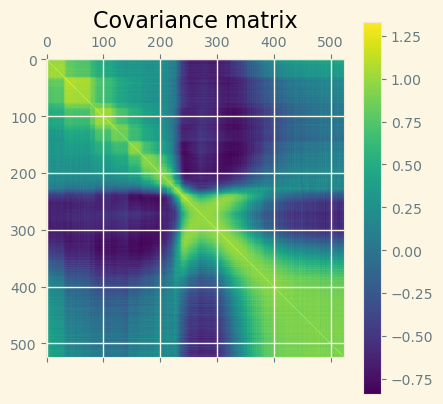

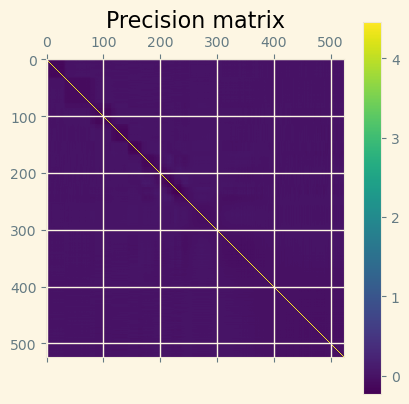

(100, 10)


In [8]:
# Documentation User Guide of methods: https://scikit-learn.org/stable/modules/decomposition.html
# Code made for fixed 10 components
# Number of features is number of columns, a function mapping a sampled object to a numeric quantity, a individual element of a vector
# Number of samples is number of rows, a single feature vector, an observation. 
from sklearn.metrics import mean_squared_error
reconstruct = []
labels = []
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

# METHOD 1: PCA --- 2.5.1.1
pca_arg_whiten = False
if pca_arg_whiten: # To aviod whiteing the data twice
    training = centre_data_train
    testing = centre_data_test
else:
    training = whiten_data_train
    testing = whiten_data_test

pca = PCA(n_components=10, whiten=pca_arg_whiten, svd_solver='auto', random_state=41) # MLE method unusable with sparse data
transformed_data = pca.fit(training).transform(testing) # (WEIGHTS IN SPECULATE) fitting training data and transforming testing data
reconstructed = pca.inverse_transform(transformed_data) # Reconstructing the test data from the method.
eigenspectra = pca.components_ # Eigenspectra, principal components
if pca_arg_whiten:
    reconstructed = (reconstructed + factors['centre']) * factors['norm_test']
else:
    reconstructed = (reconstructed*factors['whiten'] + factors['centre']) * factors['norm_test'] # Reconstructing the data from the method.

reconstruct.append(reconstructed)
print(np.shape(reconstructed))
print('=== PCA OUTPUT INFORMATION ===')
print(f'{pca.score(whiten_data_test)}: average log-likelihood of all samples')
print(f'{round(pca.explained_variance_ratio_.sum(),3)}% of the variance is explained by the first {pca.n_components} components')
print(f'{pca.singular_values_}: singular values (i.e magnitudes of the components)')
print(f'{pca.n_features_in_}: number of features')
print(f'{pca.n_samples_}: number of samples')
print(f'{pca.noise_variance_}: estimated noise covariance, average of the smallest eigenvalues')
print(f'{mean_squared_error(data_test, reconstructed)}: mean squared error between original and reconstructed data')
plt.matshow(pca.get_covariance())
plt.title('Covariance matrix')
plt.colorbar()
plt.show()
plt.matshow(pca.get_precision())
plt.title('Precision matrix')
plt.colorbar()
plt.show()
labels.append('PCA')

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

# METHOD 2: Kernel PCA --- 2.5.2
kernel_pca = KernelPCA(n_components=10, 
                       kernel='poly', 
                       gamma=0.01, 
                       degree=3,
                       #alpha=1.0,
                       fit_inverse_transform=True,
                       eigen_solver='auto',
                       random_state=42,
                       n_jobs=-1
                       )
transformed_data2 = kernel_pca.fit(whiten_data_train).transform(whiten_data_test) # fitting training data and transforming testing data
eigenvectors2 = kernel_pca.eigenvectors_
print(np.shape(eigenvectors2))
reconstructed2 = kernel_pca.inverse_transform(transformed_data2) # Reconstructing the test data from the method.
reconstructed2 = (reconstructed2*factors['whiten'] + factors['centre']) * factors['norm_test'] # Reconstructing the data from the method.
reconstruct.append(reconstructed2)
labels.append('Kernel PCA')

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

# METHOD 3: Truncated SVD --- 2.5.3
truncatedSVD = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=5, random_state=42)
transformed_data3 = truncatedSVD.fit(whiten_data_train).transform(whiten_data_test) # fitting training data and transforming testing data
reconstructed3 = truncatedSVD.inverse_transform(transformed_data3) # Reconstructing the test data from the method.
reconstructed3 = (reconstructed3*factors['whiten'] + factors['centre']) * factors['norm_test'] # Reconstructing the data from the method.
eigenspectra3 = truncatedSVD.components_ # Eigenspectra, principal components
reconstruct.append(reconstructed3)
labels.append('Truncated SVD')

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

# METHOD 4: Factor Analysis --- 2.5.5 TODO
factor_analysis = FactorAnalysis(n_components=10, random_state=42)
transformed_data4 = factor_analysis.fit(data_train).transform(data_test) # fitting training data and transforming testing data
#reconstructed4 = factor_analysis.inverse_transform(transformed_data4) # Reconstructing the test data from the method.
eigenspectra4 = factor_analysis.components_ # Eigenspectra, principal components
#reconstruct.append(reconstructed4)
#labels.append('Factor Analysis')

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

# METHOD 5: Fast ICA --- 2.5.6
fast_ica = FastICA(n_components=10, algorithm='parallel', whiten='unit-variance', random_state=42)
transformed_data5 = fast_ica.fit(data_train).transform(data_test) # fitting training data and transforming testing data
reconstructed5 = fast_ica.inverse_transform(transformed_data5) # Reconstructing the test data from the method.
eigenspectra5 = fast_ica.components_ # Eigenspectra, principal components
reconstruct.append(reconstructed5)
labels.append('Fast ICA')

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

# METHOD 6: Non-negative Matrix Factorization --- 2.5.7
nmf = NMF(n_components=10, init='random', solver='mu', beta_loss='frobenius', max_iter=1000, random_state=42)
transformed_data6 = nmf.fit(data_train).transform(data_test) # fitting training data and transforming testing data
reconstructed6 = nmf.inverse_transform(transformed_data6) # Reconstructing the test data from the method.
eigenspectra6 = nmf.components_ # Eigenspectra, principal components
reconstruct.append(reconstructed6)
labels.append('NMF')

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

# Method 7: Sparse PCA --- 2.5.1.4 (Takes longer to run)
is_fast = False # switch for sparse pca due to computational time
if is_fast:
    sparse_pca = SparsePCA(n_components=10, alpha=0.01, ridge_alpha=0.01, max_iter=1000, tol=1e-07, method='lars', n_jobs=-1, random_state=42)
    transformed_data7 = sparse_pca.fit(data_train).transform(data_test) # fitting training data and transforming testing data
    reconstructed7 = sparse_pca.inverse_transform(transformed_data7) # Reconstructing the test data from the method.
    eigenspectra7 = sparse_pca.components_ # Eigenspectra, principal components
    reconstruct.append(reconstructed7)
    labels.append('Sparse PCA')

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# Method 8: Dictionary Learning --- 2.5.4 TODO

# Method 9: Latent Dirichlet Allocation --- 2.5.8 TODO
# May not do this one as it is for text data


#### Plotting the method transformations

This cell runs a subplotting figure of each decomposition method compared against the original test data. The test spectrum can be randomly selected or specified with the `random_spectrum` variable. The variable is an index value of the test data list, hence restricted to values between 0 and 25. 

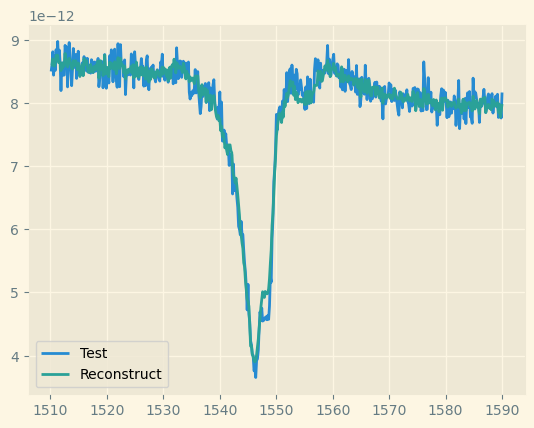

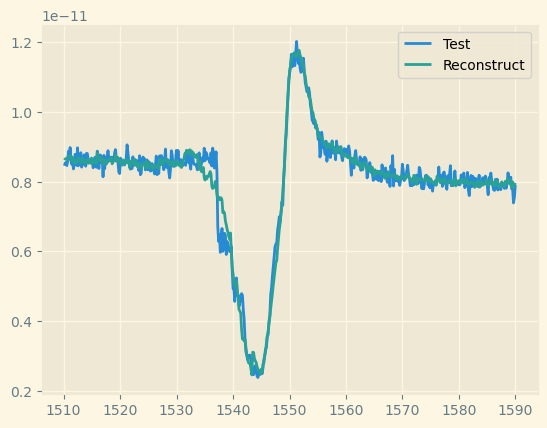

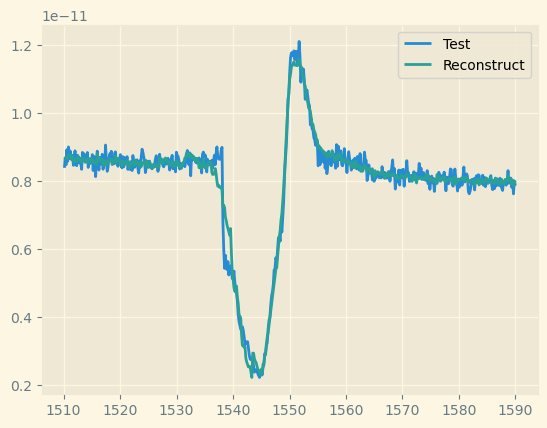

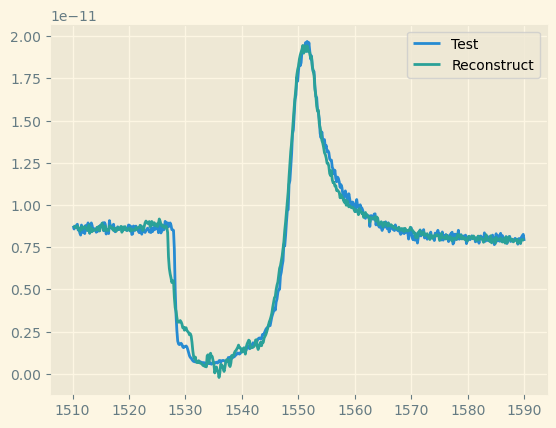

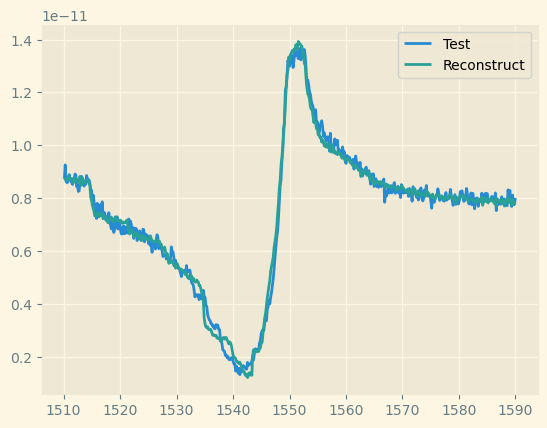

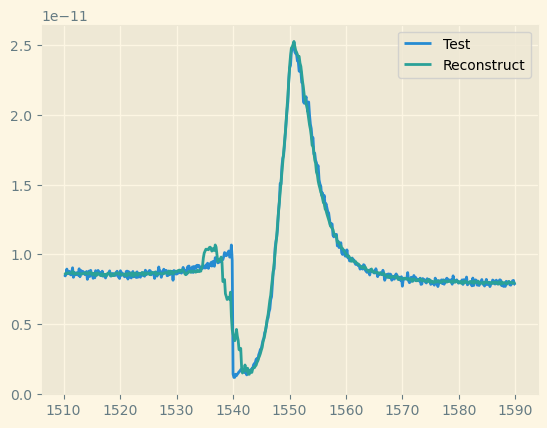

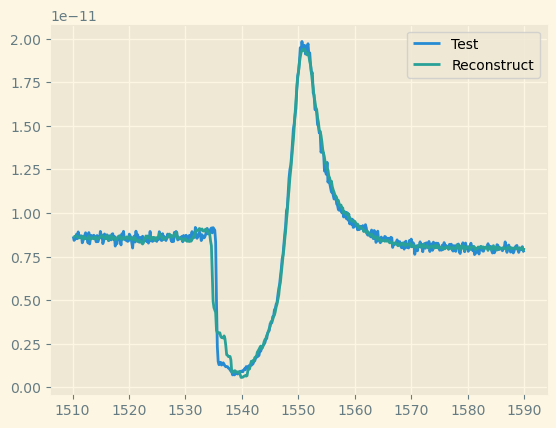

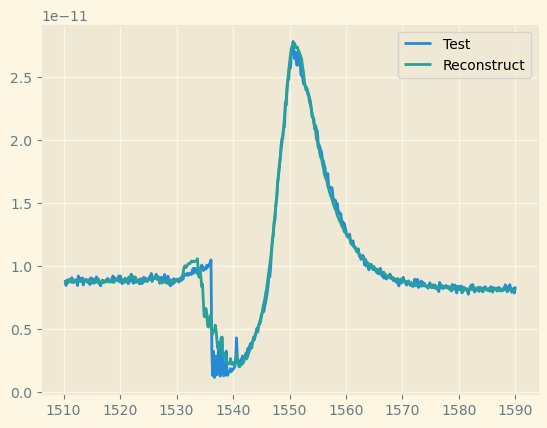

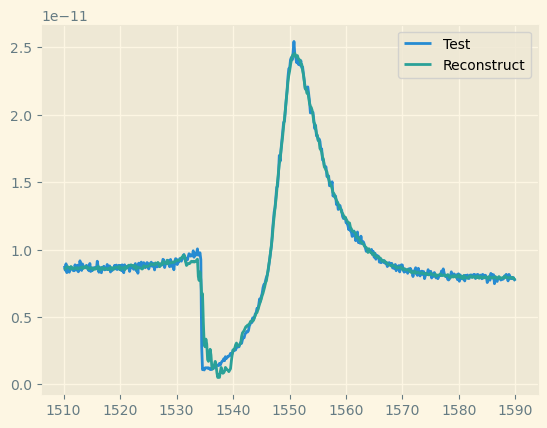

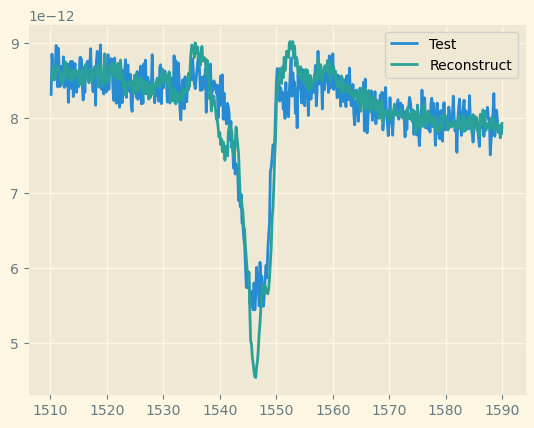

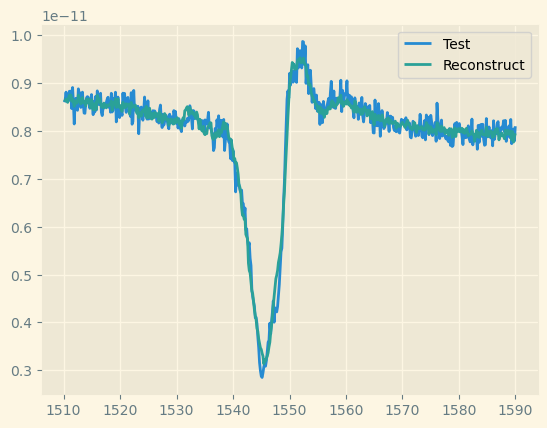

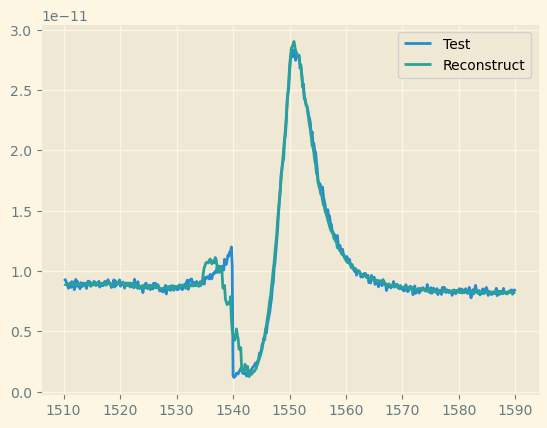

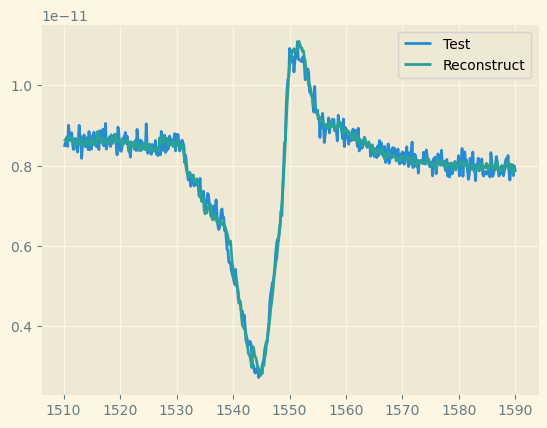

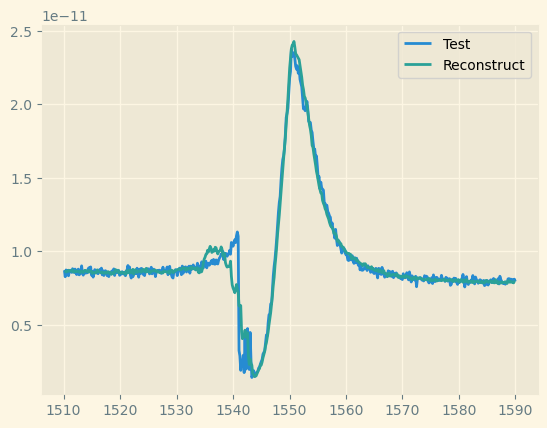

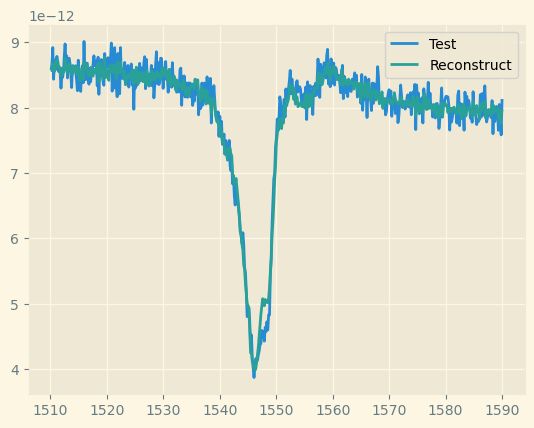

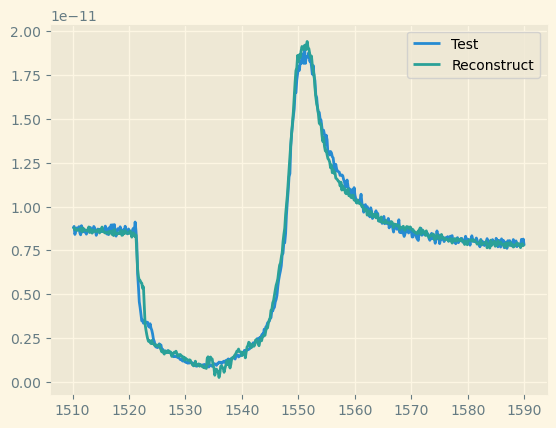

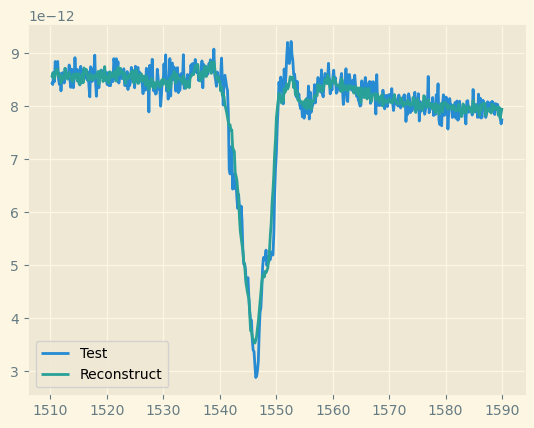

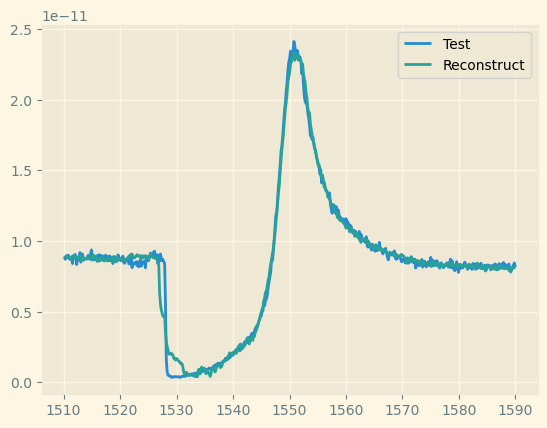

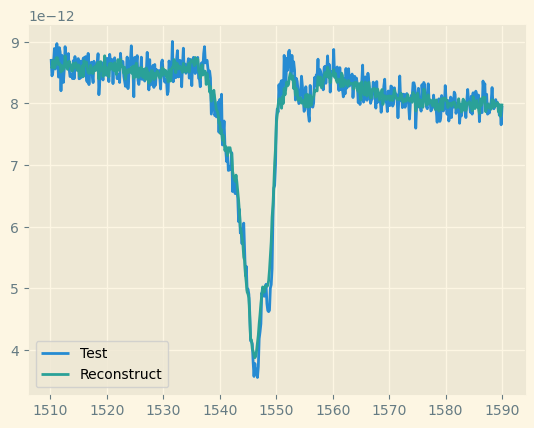

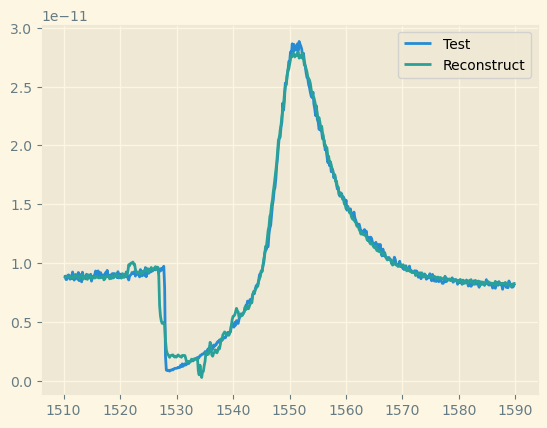

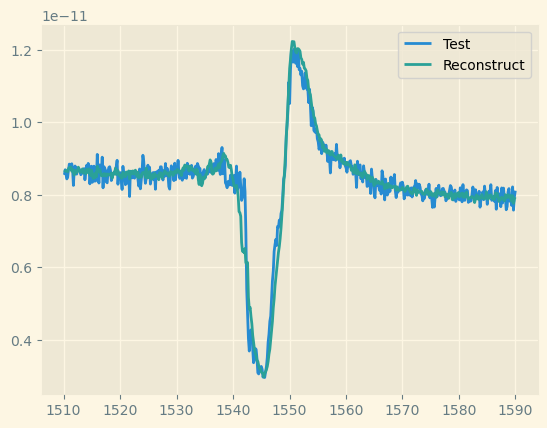

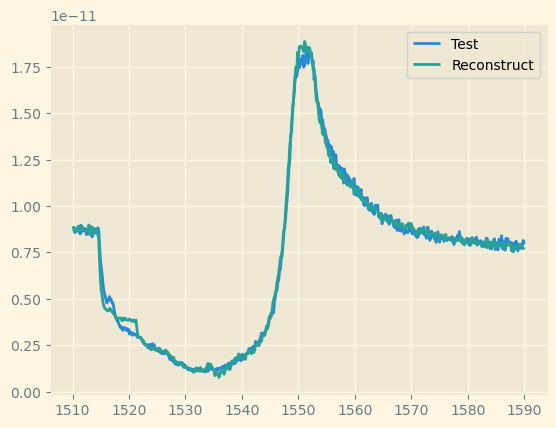

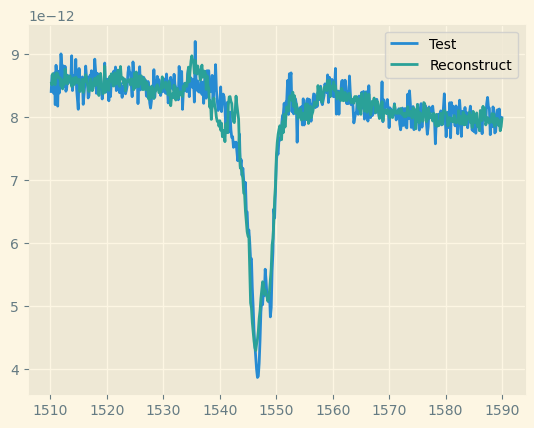

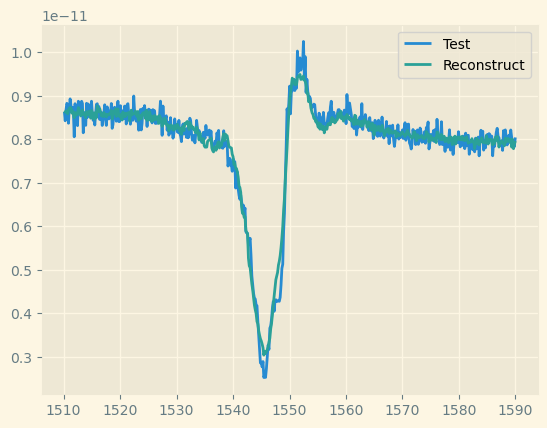

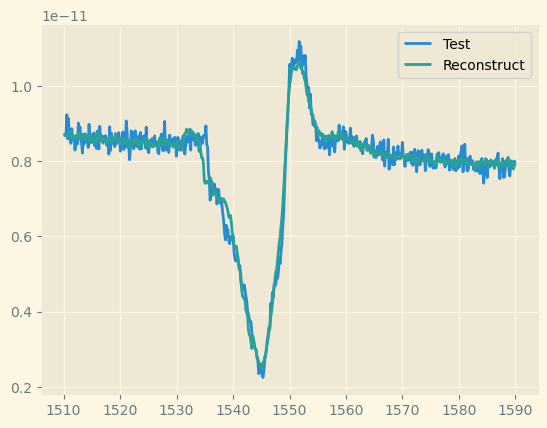

In [10]:
for i in range(len(data_test)):
    plt.plot(wavelengths, data_test[i], label='Test')
    plt.plot(wavelengths, reconstruct[0][i], label='Reconstruct')
    plt.legend()
    plt.show()

7 random index
this corresponds to grid point 123


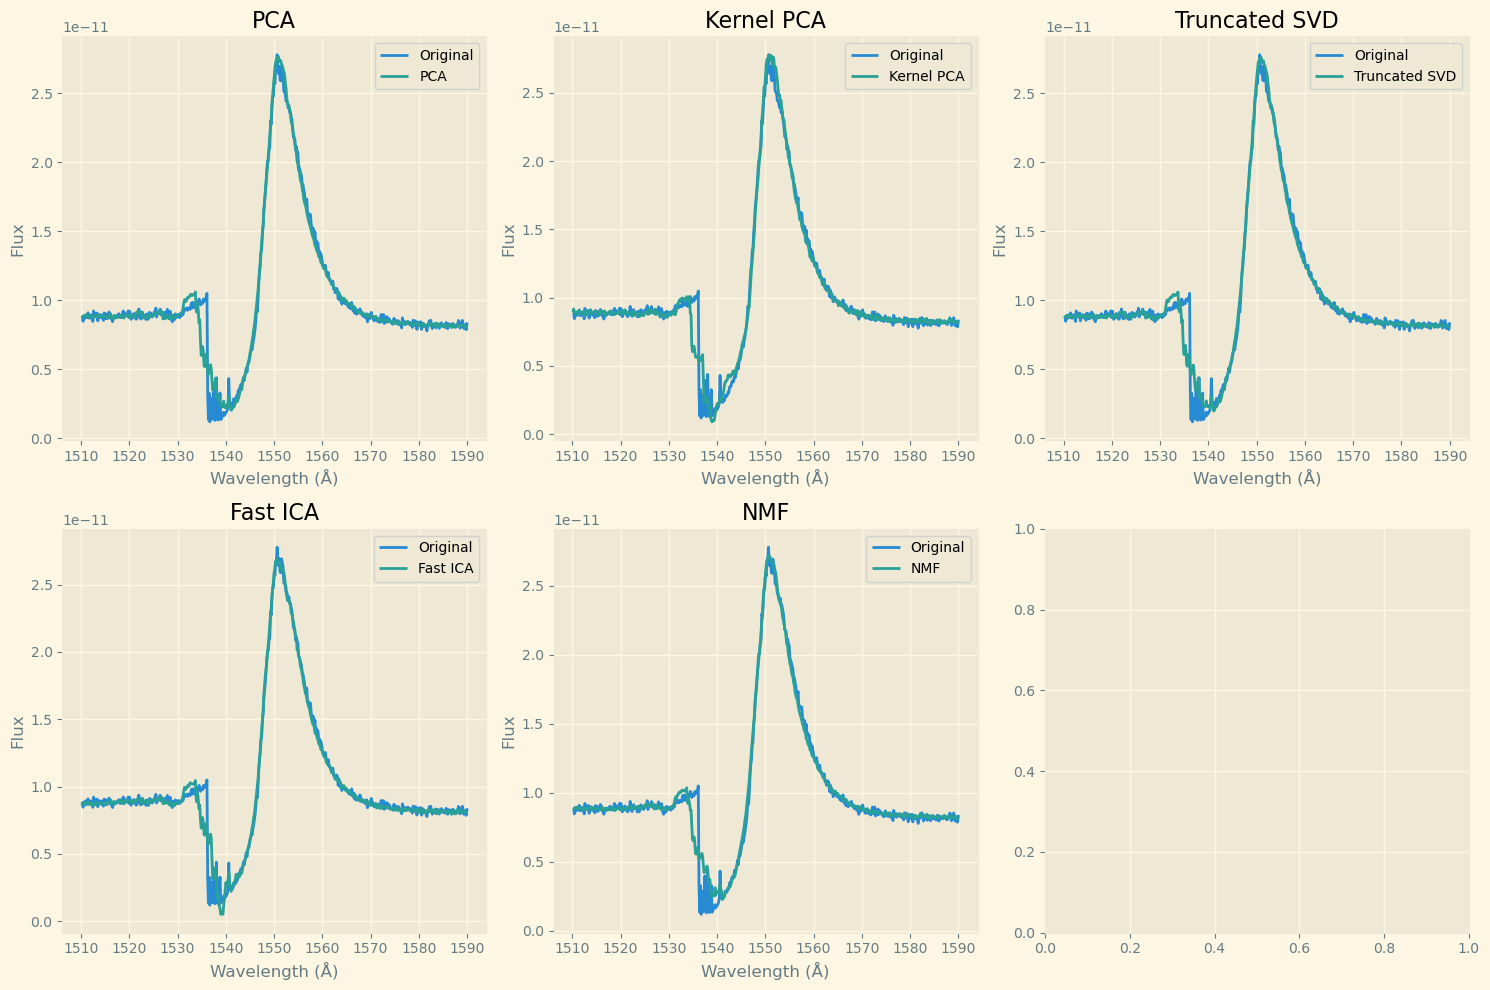

In [11]:
# Plot random spectrum and reconstructed spectrum
random_spectrum = np.random.randint(0, len(data_test))
#random_spectrum = 4 # specify random spectrum, comment out for random
print(random_spectrum, 'random index')
print('this corresponds to grid point', grid_points_test[random_spectrum])
# Plotting the random spectrm, the reconstructed spectrum and another method spectrum
fig, axs = plt.subplots(2,3, figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    if i < len(reconstruct):
        ax.plot(wavelengths, data_test[random_spectrum], label='Original')
        ax.plot(wavelengths, reconstruct[i][random_spectrum], label=labels[i])
        ax.set_title(labels[i])
        ax.set_xlabel('Wavelength (Å)')
        ax.set_ylabel('Flux')
        ax.legend()
plt.tight_layout()
plt.show()


### EIGENSPECTRA (OR EQUILIVANT) PLOTS

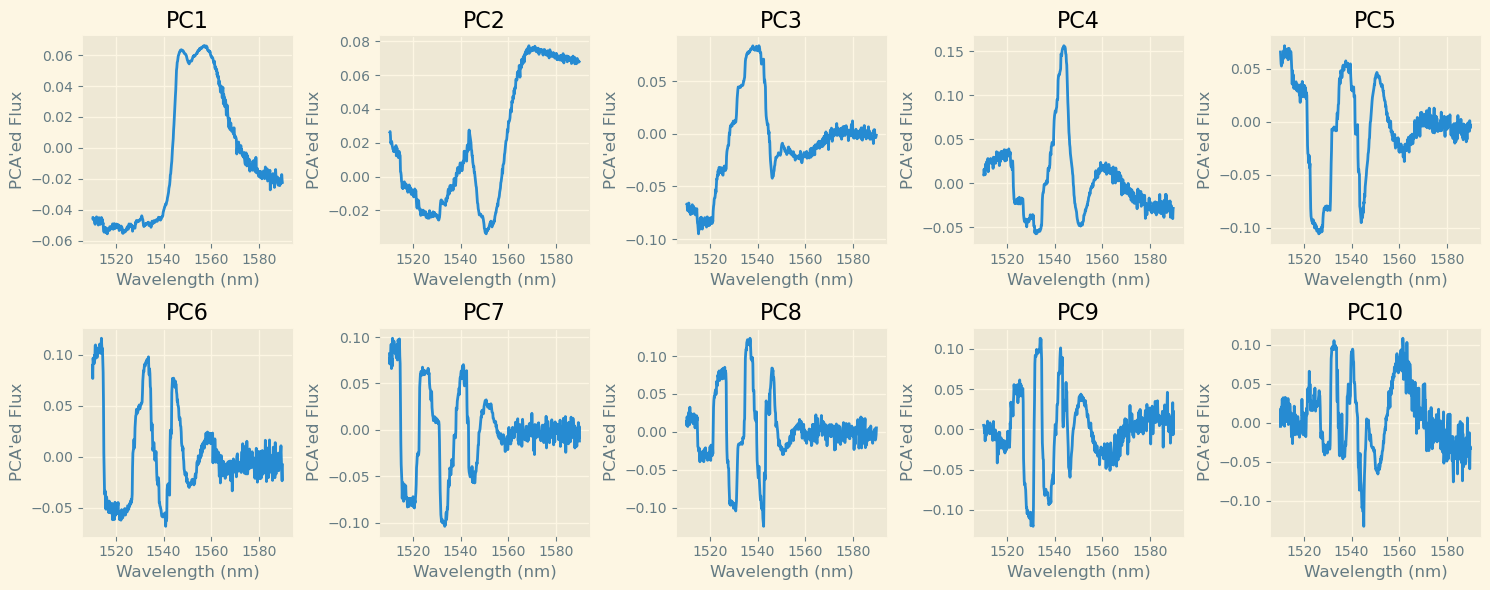

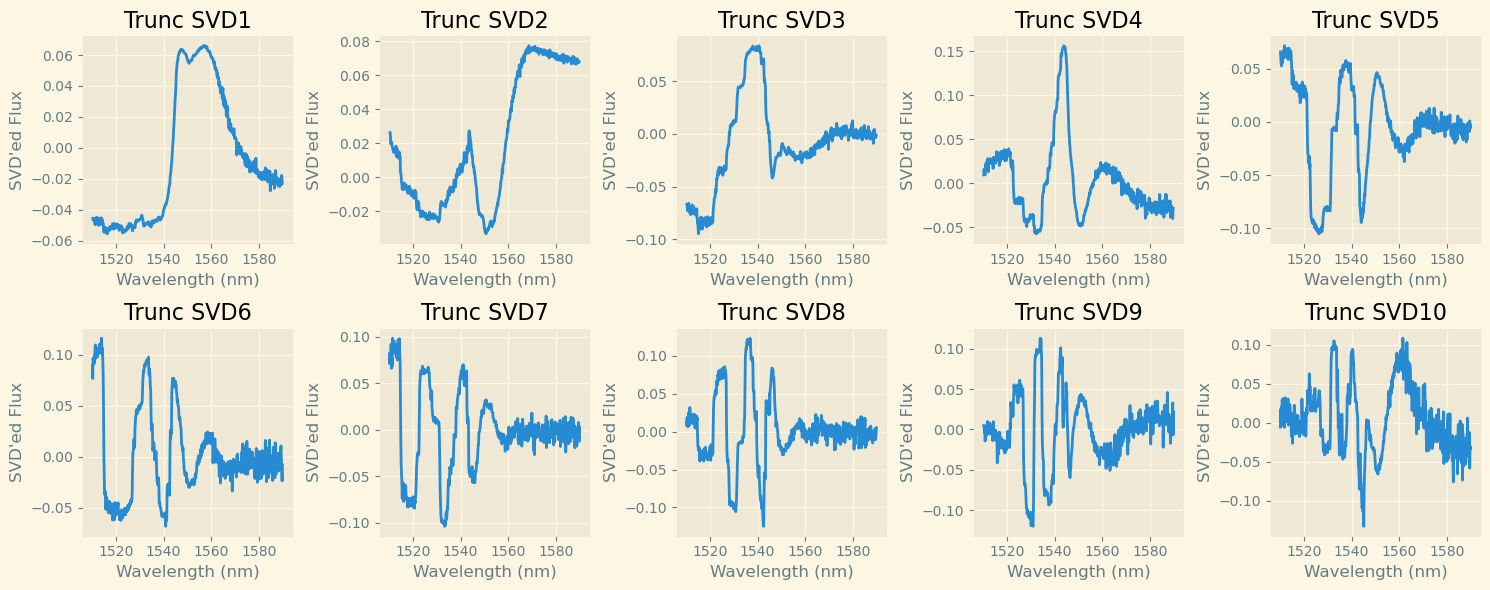

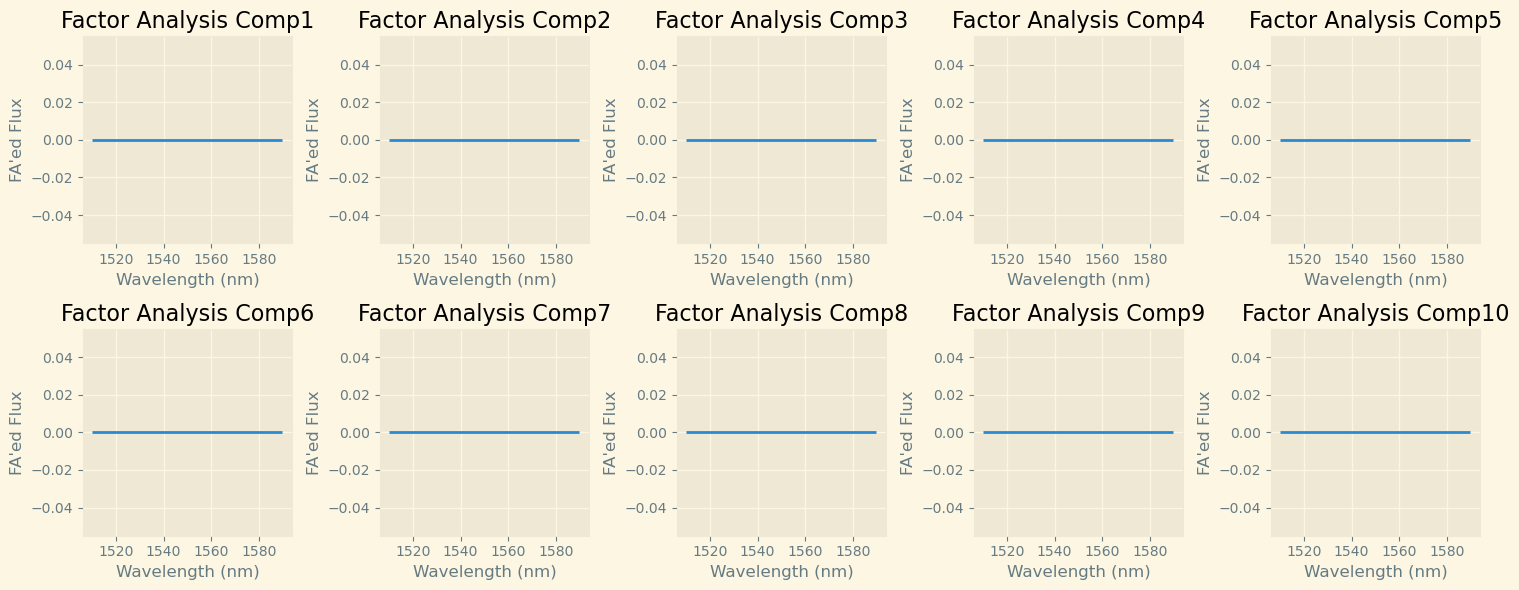

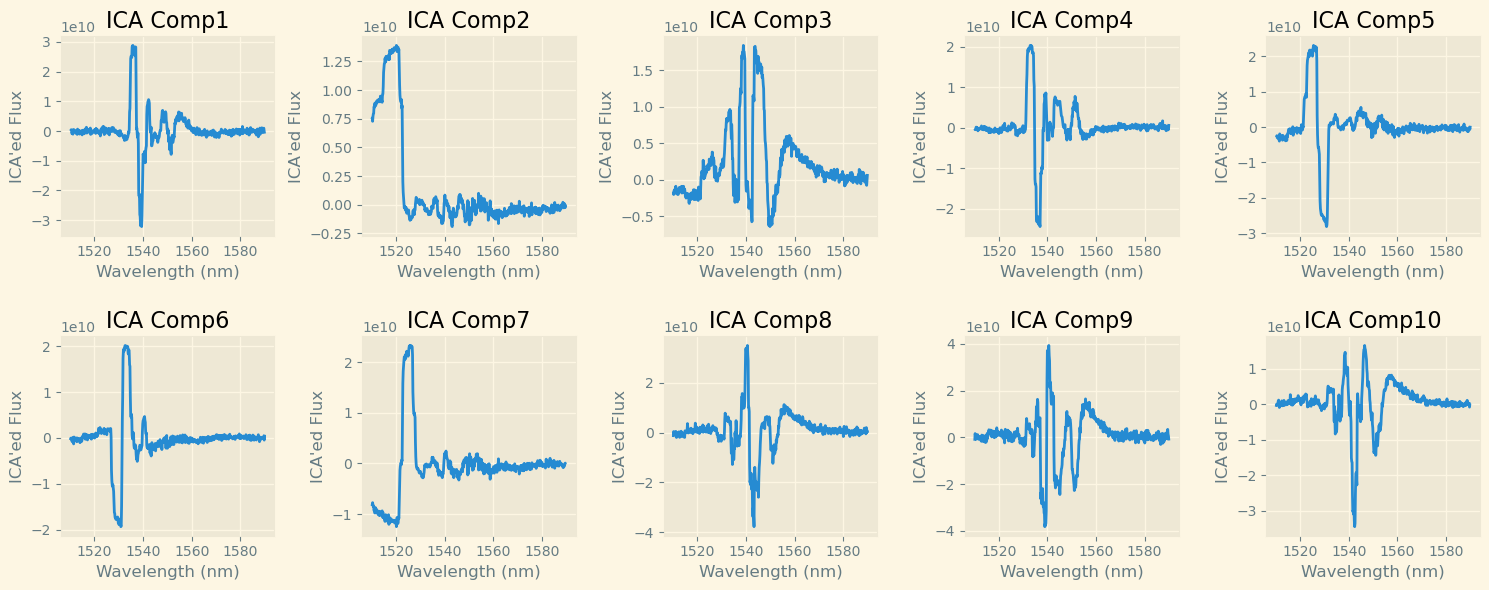

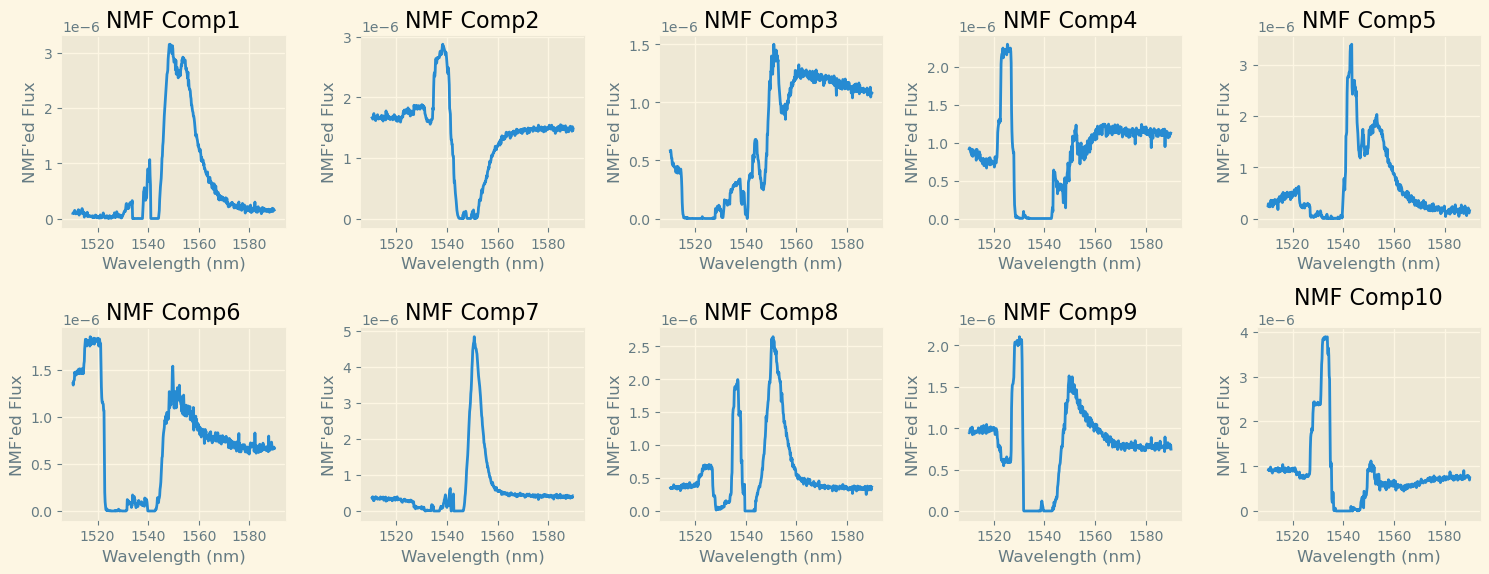

In [6]:
#TODO: Can likely loop function

# A mulitaxis plot of the first 10 principal components varying subplots to the correct number of components
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.plot(wavelengths, eigenspectra[i])
    ax.set_title(f'PC{i+1}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("PCA'ed Flux")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.plot(wavelengths, eigenspectra3[i])
    ax.set_title(f'Trunc SVD{i+1}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("SVD'ed Flux")
plt.tight_layout()
plt.show()

# A mulitaxis plot of the first 10 principal components varying subplots to the correct number of components
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.plot(wavelengths, eigenspectra4[i])
    ax.set_title(f'Factor Analysis Comp{i+1}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("FA'ed Flux")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.plot(wavelengths, eigenspectra5[i])
    ax.set_title(f'ICA Comp{i+1}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("ICA'ed Flux")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.plot(wavelengths, eigenspectra6[i])
    ax.set_title(f'NMF Comp{i+1}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("NMF'ed Flux")
plt.tight_layout()
plt.show()

is_fast = False # switch for sparse pca due to computational time
if is_fast:
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axs.flatten()):
        ax.plot(wavelengths, eigenspectra7[i])
        ax.set_title(f'Sparse PCA Comp{i+1}')
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel("SPCA'ed Flux")
    plt.tight_layout()
    plt.show()

### Weights plotting (TODO)

### KERNEL PCA (no test data, all data used as training)

(125, 10) weights (grid points, components)


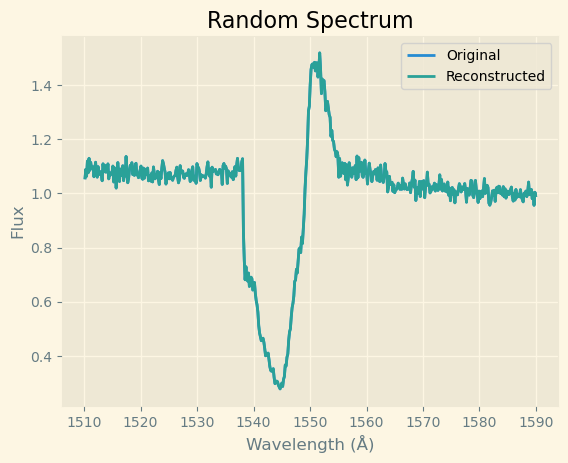

In [7]:
from sklearn.decomposition import KernelPCA

data = normalised_grid

kernel_pca = KernelPCA(n_components=10, kernel='poly', gamma=0.1, degree = 3, fit_inverse_transform=True)
transformed_data = kernel_pca.fit_transform(data)
print(transformed_data.shape, 'weights (grid points, components)')
reconstructed100 = kernel_pca.inverse_transform(transformed_data) # Reconstructing the data from the weights

# Plot random spectrum and reconstructed spectrum
random_spectrum = np.random.randint(0, len(data))
random_spectrum = 36

plt.plot(wavelengths, data[random_spectrum], label='Original')
plt.plot(wavelengths, reconstructed100[random_spectrum], label='Reconstructed')

plt.title('Random Spectrum')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.legend()
plt.show()